In [1]:
import numpy as np
import loguru
import time
import json
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
with open('../configs/elm_configs.json', 'r') as f:
    configs = json.load(f)
num_classes = configs['num_classes']
num_hidden_layers = configs['num_hidden_layers']
input_length = configs['input_length']

In [4]:
x_train = x_train.reshape(-1, input_length).astype(np.float32) / 255.0
x_test = x_test.reshape(-1, input_length).astype(np.float32) / 255.0

In [5]:
y_train = to_categorical(y_train, num_classes).astype(np.float32)
y_test = to_categorical(y_test, num_classes).astype(np.float32)

In [6]:
def _mean_squared_error(y, pred):
    return 0.5 * np.mean((y - pred) ** 2)

def _mean_abs_error(y, pred):
    return np.mean(np.abs(y, pred))

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))


def _fourier(x):
    return np.sin(x)


def _hardlimit(x):
    return (x >= 0).astype(int)


def _identity(x):
    return x


def getActivation(name):
    if name not in ['sigmoid', 'fourier', 'hardlimit', 'identity']:
        raise ValueError('Unknown activation function: %s' % name)
    
    return {
        'sigmoid': _sigmoid,
        'fourier': _fourier,
        'hardlimit': _hardlimit,
        'identity': _identity
    }[name]


def getLoss(name):
    if name not in ['mse', 'mae']:
        raise ValueError('Unknown loss function: %s' % name)
    
    return {
        'mse': _mean_squared_error,
        'mae': _mean_abs_error
    }[name]

In [7]:
class ELM:
    def __init__(self, 
                 num_input_nodes: int, 
                 num_hidden_units: int, 
                 num_out_units: int,
                 activation: str='sigmoid', 
                 loss: str ='mse', 
                 beta_init: np.ndarray=None, 
                 w_init: np.ndarray=None, 
                 bias_init: np.ndarray=None):
        
        self._num_input_nodes = num_input_nodes
        self._num_hidden_units = num_hidden_units
        self._num_out_units = num_out_units

        self._activation = getActivation(activation)
        self._loss = getLoss(loss)
        
        if isinstance(beta_init, np.ndarray):
            self._beta = beta_init
        else:
            self._beta = np.random.uniform(-1., 1., size=(self._num_hidden_units, self._num_out_units))

        if isinstance(w_init, np.ndarray):
            self._w = w_init
        else:
            self._w = np.random.uniform(-1, 1, size=(self._num_input_nodes, self._num_hidden_units))

        if isinstance(bias_init, np.ndarray):
            self._bias = bias_init
        else:
            self._bias = np.zeros(shape=(self._num_hidden_units,))

        loguru.logger.debug(f'Beta: {self._beta.shape}')
        loguru.logger.debug(f'Weights: {self._w.shape}')
        loguru.logger.debug(f'Bias: {self._bias.shape}')
    
    def fit(self, X, y, display_time=False):
        H = self._activation(X.dot(self._w) + self._bias)
        
        # Moore-Penrose pseudo inverse
        if display_time:
            start_time = time.time()
        H_pinv = np.linalg.pinv(H)
        if display_time:
            stop_time = time.time()
            loguru.logger.debug(f'Pseudo inverse took {stop_time - start_time:.4f} seconds')
        
        self._beta = H_pinv.dot(y)
    
    def __call__(self, X):
        H = self._activation(X.dot(self._w) + self._bias)
        return H.dot(self._beta)

    def evaluate(self, X, y):
        pred = self(X)
        loss = self._loss(y, pred)
        acc = np.sum(np.argmax(pred, axis=1) == np.argmax(y, axis=1)) / len(y)
        return loss, acc

In [8]:
# create instance of our model
model = ELM(
    input_length,
    num_hidden_layers,
    num_classes
)

2024-04-05 15:52:11.971 | DEBUG    | __main__:__init__:34 - Beta: (2048, 10)
2024-04-05 15:52:11.973 | DEBUG    | __main__:__init__:35 - Weights: (784, 2048)
2024-04-05 15:52:11.973 | DEBUG    | __main__:__init__:36 - Bias: (2048,)


In [11]:
# Train
model.fit(x_train, y_train, display_time=True)

2024-04-05 15:56:02.449 | DEBUG    | __main__:fit:47 - Pseudo inverse took 22.0300 seconds


In [12]:
train_loss, train_acc = model.evaluate(x_train, y_train)
print('train loss: %f' % train_loss)
print('train acc: %f' % train_acc)

train loss: 0.008793
train acc: 0.960867


In [10]:
# Validation
val_loss, val_acc = model.evaluate(x_test, y_test)
print('val loss: %f' % val_loss)
print('val acc: %f' % val_acc)

val loss: 0.009264
val acc: 0.953800


In [45]:
import pickle

with open('../model/elm/bias.pickle', 'wb') as f:
    pickle.dump(model._bias, f, protocol=pickle.HIGHEST_PROTOCOL)
with open('../model/elm/w.pickle', 'wb') as f:
    pickle.dump(model._w, f, protocol=pickle.HIGHEST_PROTOCOL)
with open('../model/elm/beta.pickle', 'wb') as f:
    pickle.dump(model._beta, f, protocol=pickle.HIGHEST_PROTOCOL)

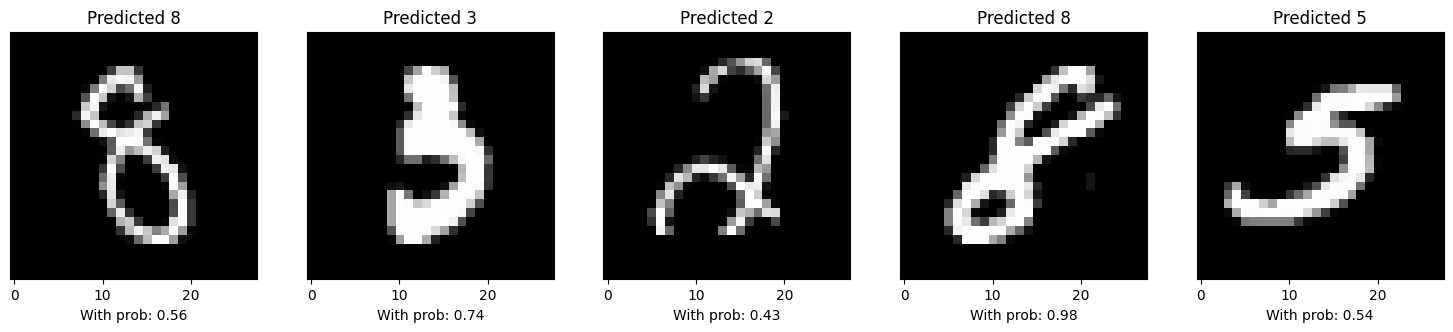

In [47]:
import matplotlib.pyplot as plt

# Predictions
test_data = x_test[np.random.choice(len(x_test), size=5, replace=False)]
predictions = model(test_data)

fig, axs = plt.subplots(1, 5)
fig.set_size_inches(18.5, 10.5)
for idx, image in enumerate(test_data):
    image = np.array(image, dtype='float')
    pixels = image.reshape((28, 28))
    axs[idx].imshow(pixels, cmap='gray')
    axs[idx].axes.get_yaxis().set_visible(False)
    axs[idx].title.set_text(f'Predicted {np.argmax(predictions[idx])}')
    axs[idx].set_xlabel(f'With prob: {str(round(np.max(predictions[idx]), 2))}')
    
    
plt.show()